<a href="https://colab.research.google.com/github/adkBMW/TelecomX_Churn_Prediction/blob/main/TelecomX_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paso 1: Extracción del Archivo Tratado

In [1]:
# --- 1. Importar librerias ---
import pandas as pd
import requests
from pandas import json_normalize

# --- 2. Cargar datos desde la API ---
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url)
data = response.json()
df = pd.DataFrame(data)

# --- 3. Normalizar columnas con diccionarios ---
columnas_dict = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, dict)).any()]
for col in columnas_dict:
    df_normalized = json_normalize(df[col])
    df_normalized.columns = [f"{col}_{subcol}" for subcol in df_normalized.columns]
    df = df.drop(col, axis=1).join(df_normalized)

# --- 4. Manejo de inconsistencias ---
# Corregir valores vacíos en Churn
df['Churn'] = df['Churn'].replace('', 'no')

# Convertir account_Charges.Total a numérico
df['account_Charges.Total'] = pd.to_numeric(df['account_Charges.Total'], errors='coerce')

# Estandarizar columnas categóricas
columnas_categoricas = df.select_dtypes(include=['object']).columns
for col in columnas_categoricas:
    df[col] = df[col].str.lower()

# Clasificación de tipo de pago
df['calculo_total'] = df['account_Charges.Monthly'] * df['customer_tenure']
df['tipo_pago'] = ['mensual' if abs(total - calc) < 1 else 'pago_unico'
                   for total, calc in zip(df['account_Charges.Total'], df['calculo_total'])]

# Eliminar columna temporal
df = df.drop('calculo_total', axis=1)

# --- 5. Creación de columna Cuentas_Diarias ---
df['Cuentas_Diarias'] = df['account_Charges.Monthly'] / 30

# --- 6. Verificación final ---
print("Primeras filas del DataFrame consolidado:")
display(df.head())

print("\nTipos de datos y valores nulos:")
print(df.info())
print(df.isnull().sum())


Primeras filas del DataFrame consolidado:


,customerID,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,...,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges.Monthly,account_Charges.Total,tipo_pago,Cuentas_Diarias
0,0002-orfbo,no,female,0,yes,yes,9,yes,no,dsl,...,yes,yes,no,one year,yes,mailed check,65.6,593.30,pago_unico,2.186667
1,0003-mknfe,no,male,0,no,no,9,yes,yes,dsl,...,no,no,yes,month-to-month,no,mailed check,59.9,542.40,pago_unico,1.996667
2,0004-tlhlj,yes,male,0,no,no,4,yes,no,fiber optic,...,no,no,no,month-to-month,yes,electronic check,73.9,280.85,pago_unico,2.463333
3,0011-igkff,yes,male,1,yes,no,13,yes,no,fiber optic,...,no,yes,yes,month-to-month,yes,electronic check,98.0,1237.85,pago_unico,3.266667
4,0013-exchz,yes,female,1,yes,no,3,yes,no,fiber optic,...,yes,yes,no,month-to-month,yes,mailed check,83.9,267.40,pago_unico,2.796667



Tipos de datos y valores nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_SeniorCitizen     7267 non-null   int64  
 4   customer_Partner           7267 non-null   object 
 5   customer_Dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_PhoneService         7267 non-null   object 
 8   phone_MultipleLines        7267 non-null   object 
 9   internet_InternetService   7267 non-null   object 
 10  internet_OnlineSecurity    7267 non-null   object 
 11  internet_OnlineBackup      7267 non-null   object 
 12  internet_DeviceProtection  7267 non-null   object 
 13  internet_TechSu

Paso 2: Eliminación de Columnas Irrelevantes

In [2]:
# Lista de columnas que no aportan valor para la predicción
columnas_irrelevantes = [
    'customerID',  # identificador único
    # Si hubiera otras columnas irrelevantes, se agregan aquí
]

# Eliminamos las columnas
df = df.drop(columnas_irrelevantes, axis=1)

# Verificación de columnas restantes
print("Columnas restantes después de eliminar irrelevantes:")
print(df.columns)


Columnas restantes después de eliminar irrelevantes:
Index(['Churn', 'customer_gender', 'customer_SeniorCitizen',
       'customer_Partner', 'customer_Dependents', 'customer_tenure',
       'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService',
       'internet_OnlineSecurity', 'internet_OnlineBackup',
       'internet_DeviceProtection', 'internet_TechSupport',
       'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract',
       'account_PaperlessBilling', 'account_PaymentMethod',
       'account_Charges.Monthly', 'account_Charges.Total', 'tipo_pago',
       'Cuentas_Diarias'],
      dtype='object')


Paso 3: Codificación de variables categóricas

In [3]:
# Identificar columnas categóricas (tipo object)
columnas_categoricas = df.select_dtypes(include=['object']).columns
print("Columnas categóricas a codificar:", list(columnas_categoricas))

# Aplicar One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=columnas_categoricas, drop_first=True)

# Verificar resultado
print("\nPrimeras filas del DataFrame codificado:")
display(df_encoded.head())

print("\nColumnas totales después de codificación:", df_encoded.shape[1])

Columnas categóricas a codificar: ['Churn', 'customer_gender', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'tipo_pago']

Primeras filas del DataFrame codificado:


,customer_SeniorCitizen,customer_tenure,account_Charges.Monthly,account_Charges.Total,Cuentas_Diarias,Churn_yes,customer_gender_male,customer_Partner_yes,customer_Dependents_yes,phone_PhoneService_yes,...,internet_StreamingTV_yes,internet_StreamingMovies_no internet service,internet_StreamingMovies_yes,account_Contract_one year,account_Contract_two year,account_PaperlessBilling_yes,account_PaymentMethod_credit card (automatic),account_PaymentMethod_electronic check,account_PaymentMethod_mailed check,tipo_pago_pago_unico
0,0,9,65.6,593.30,2.186667,False,False,True,True,True,...,True,False,False,True,False,True,False,False,True,True
1,0,9,59.9,542.40,1.996667,False,True,False,False,True,...,False,False,True,False,False,False,False,False,True,True
2,0,4,73.9,280.85,2.463333,True,True,False,False,True,...,False,False,False,False,False,True,False,True,False,True
3,1,13,98.0,1237.85,3.266667,True,True,True,False,True,...,True,False,True,False,False,True,False,True,False,True
4,1,3,83.9,267.40,2.796667,True,False,True,False,True,...,True,False,False,False,False,True,False,False,True,True



Columnas totales después de codificación: 33


Paso 4: Verificación de la proporción de Churn

Conteo de clientes según Churn:
Churn
no     5398
yes    1869
Name: count, dtype: int64

Proporción de clientes según Churn (%):
Churn
no     74.280996
yes    25.719004
Name: proportion, dtype: float64


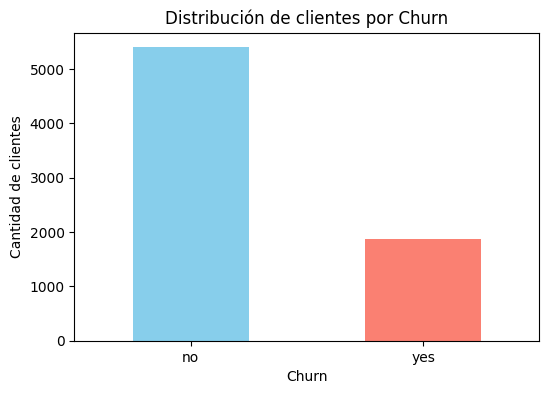

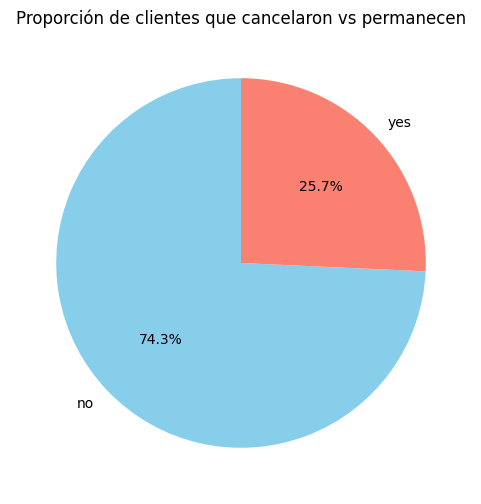

In [5]:
# Revisar si la columna 'Churn' existe en el DataFrame
if 'Churn' in df.columns:
    churn_col = 'Churn'
elif 'Churn_yes' in df.columns:  # En caso de que se haya hecho get_dummies
    churn_col = 'Churn_yes'
else:
    raise KeyError("La columna 'Churn' no se encuentra en el DataFrame.")

# Conteo de clientes que cancelaron y los que permanecen
conteo_churn = df[churn_col].value_counts()
proporcion_churn = df[churn_col].value_counts(normalize=True) * 100

print("Conteo de clientes según Churn:")
print(conteo_churn)
print("\nProporción de clientes según Churn (%):")
print(proporcion_churn)

# Visualización de la proporción
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
conteo_churn.plot(kind='bar', color=['skyblue','salmon'])
plt.title('Distribución de clientes por Churn')
plt.xlabel('Churn')
plt.ylabel('Cantidad de clientes')
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(6,6))
conteo_churn.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue','salmon'], startangle=90)
plt.ylabel('')
plt.title('Proporción de clientes que cancelaron vs permanecen')
plt.show()

Paso 5: Balanceo de clases con SMOTE (opcional)

In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import pandas as pd

# Separar variables independientes y objetivo
X = df.drop(columns=['Churn'])
y = df['Churn']

# Transformar variables categóricas restantes con get_dummies si es necesario
categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Imputar valores faltantes
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.3, random_state=42, stratify=y
)

# Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Verificar balanceo
print("Distribución original de clases en y_train:")
print(y_train.value_counts())
print("\nDistribución después de SMOTE en y_train_bal:")
print(pd.Series(y_train_bal).value_counts())


Distribución original de clases en y_train:
Churn
no     3778
yes    1308
Name: count, dtype: int64

Distribución después de SMOTE en y_train_bal:
Churn
no     3778
yes    3778
Name: count, dtype: int64


Paso 6: Análisis de Correlación

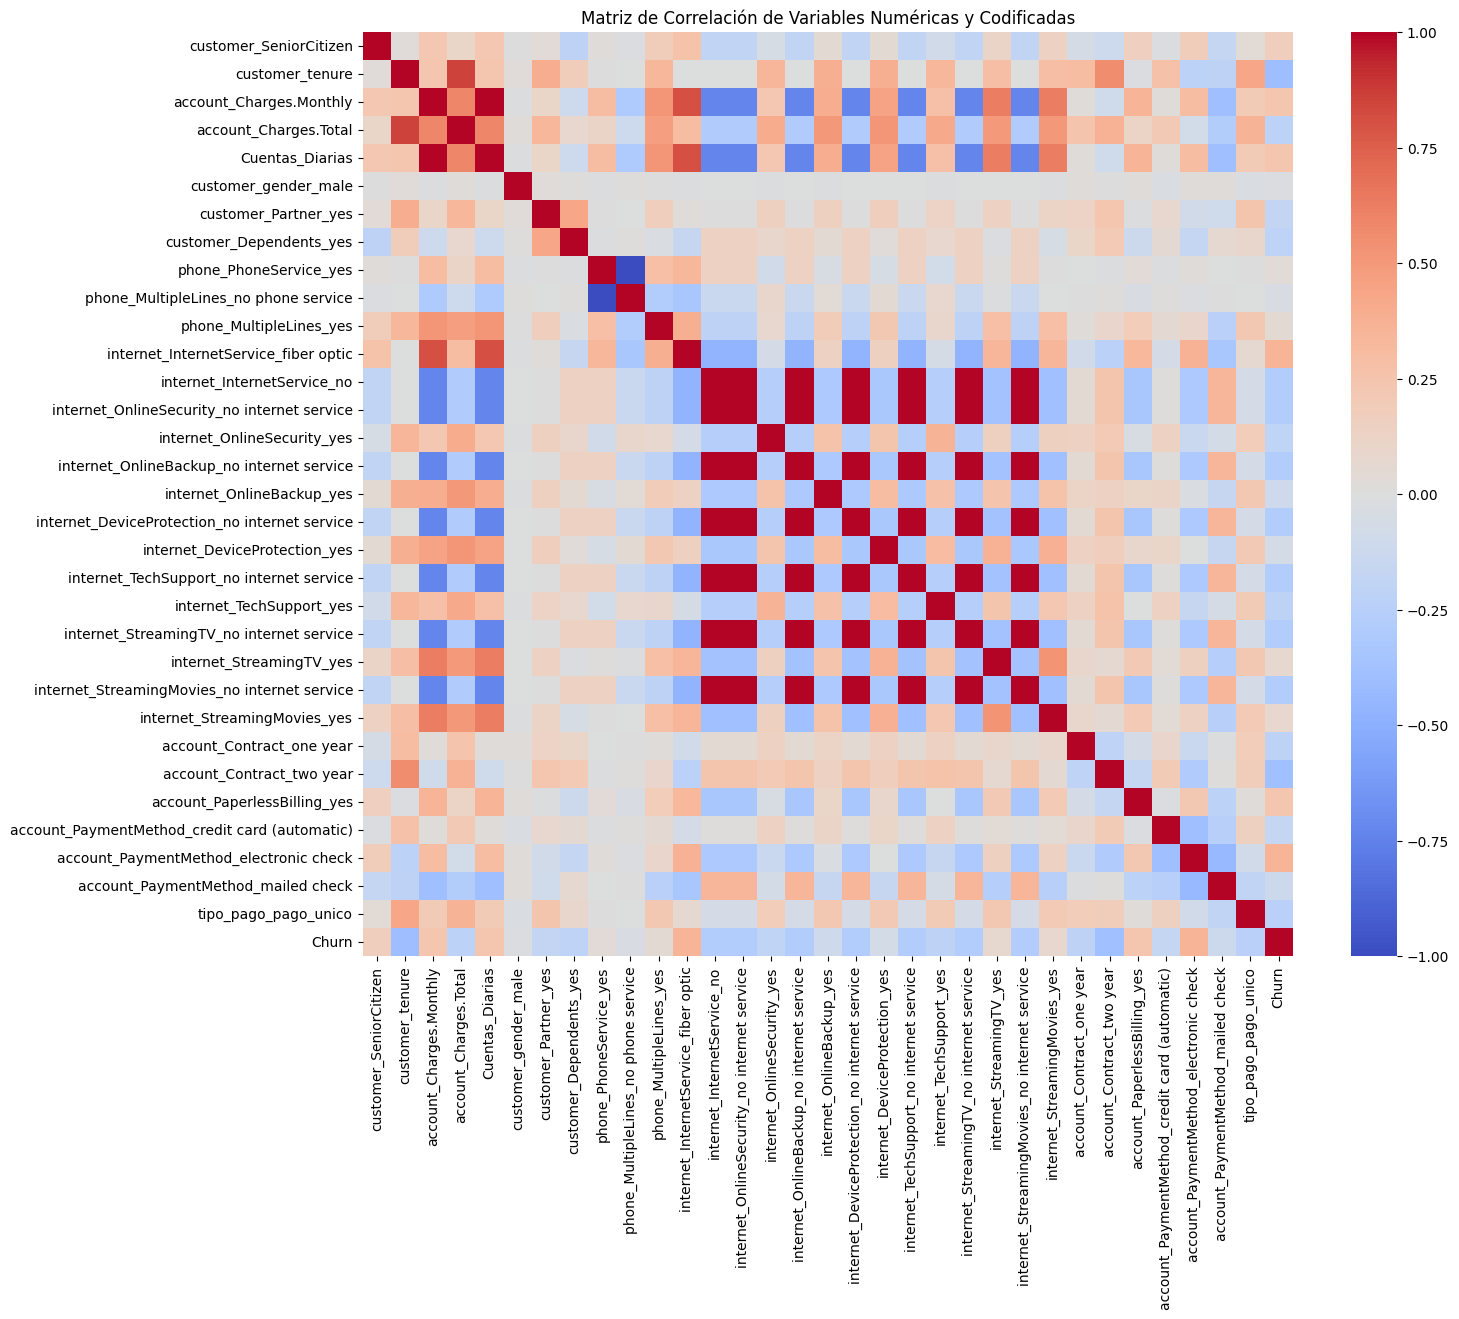

Correlación de cada variable con Churn:
Churn                                            1.000000
internet_InternetService_fiber optic             0.356307
account_PaymentMethod_electronic check           0.353079
account_PaperlessBilling_yes                     0.238479
account_Charges.Monthly                          0.237478
Cuentas_Diarias                                  0.237478
customer_SeniorCitizen                           0.164597
internet_StreamingMovies_yes                     0.080970
internet_StreamingTV_yes                         0.070835
phone_MultipleLines_yes                          0.046878
phone_PhoneService_yes                           0.033183
customer_gender_male                            -0.019442
phone_MultipleLines_no phone service            -0.033183
internet_DeviceProtection_yes                   -0.073147
internet_OnlineBackup_yes                       -0.103006
account_PaymentMethod_mailed check              -0.120267
account_PaymentMethod_credit car

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Mapear columna objetivo Churn a 0/1 ---
y_train_bal = y_train_bal.str.lower().map({'no': 0, 'yes': 1})

# --- 2. Mapear columnas binarias a 0/1 ---
binary_cols = ['customer_gender', 'customer_Partner', 'customer_Dependents',
               'phone_PhoneService', 'phone_MultipleLines',
               'internet_OnlineSecurity', 'internet_OnlineBackup',
               'internet_DeviceProtection', 'internet_TechSupport',
               'internet_StreamingTV', 'internet_StreamingMovies',
               'account_PaperlessBilling']

for col in binary_cols:
    if col in X_train_bal.columns:
        X_train_bal[col] = X_train_bal[col].str.lower().map({'no':0,'yes':1})

# --- 3. Aplicar One-Hot Encoding a las columnas categóricas restantes ---
X_encoded = pd.get_dummies(X_train_bal, drop_first=True)

# --- 4. Concatenar con la variable objetivo ---
df_corr = pd.concat([X_encoded, y_train_bal.reset_index(drop=True)], axis=1)

# --- 5. Calcular matriz de correlación ---
corr_matrix = df_corr.corr()

# --- 6. Visualizar matriz de correlación ---
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', cbar=True)
plt.title("Matriz de Correlación de Variables Numéricas y Codificadas")
plt.show()

# --- 7. Correlación con la variable objetivo Churn ---
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)
print("Correlación de cada variable con Churn:")
print(churn_corr)


Paso 7: Análisis Dirigido

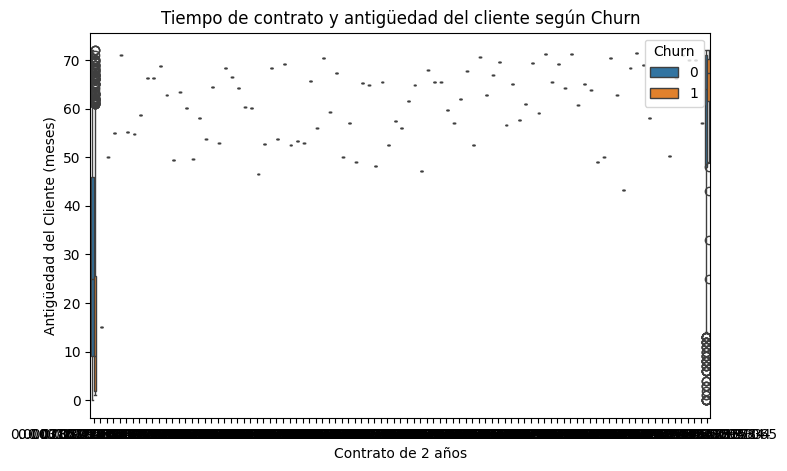

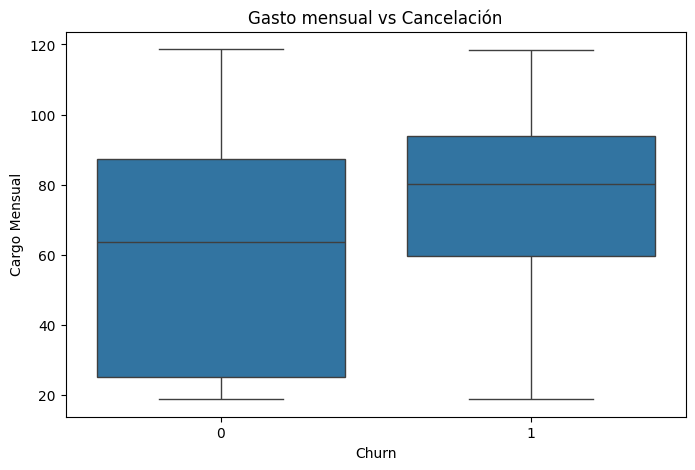

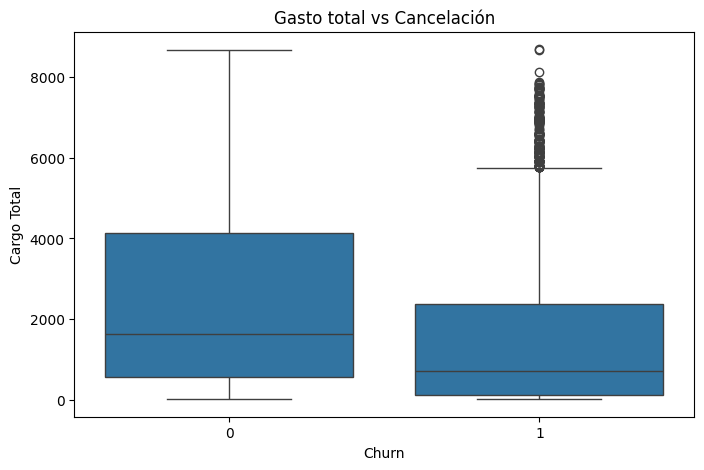

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarnos de que 'Churn' esté en formato categórico
df_corr['Churn'] = df_corr['Churn'].astype(int)

# --- 1. Tiempo de contrato vs Cancelación ---
plt.figure(figsize=(8,5))
sns.boxplot(x='account_Contract_two year', y='customer_tenure', hue='Churn', data=df_corr)
plt.title("Tiempo de contrato y antigüedad del cliente según Churn")
plt.ylabel("Antigüedad del Cliente (meses)")
plt.xlabel("Contrato de 2 años")
plt.legend(title="Churn", loc='upper right')
plt.show()

# --- 2. Gasto mensual vs Cancelación ---
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='account_Charges.Monthly', data=df_corr)
plt.title("Gasto mensual vs Cancelación")
plt.ylabel("Cargo Mensual")
plt.xlabel("Churn")
plt.show()

# --- 3. Gasto total vs Cancelación ---
plt.figure(figsize=(8,5))
sns.boxplot(x='Churn', y='account_Charges.Total', data=df_corr)
plt.title("Gasto total vs Cancelación")
plt.ylabel("Cargo Total")
plt.xlabel("Churn")
plt.show()


Paso 8: Modelado Predictivo – Separación de Datos

In [27]:
from sklearn.model_selection import train_test_split

# Variables predictoras (X) y variable objetivo (y)
X = X_encoded  # DataFrame con todas las variables numéricas y codificadas
y = df_corr['Churn']  # Variable objetivo

# División de los datos: 70% entrenamiento, 30% prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Verificar tamaños de los conjuntos
print("Tamaño X_train:", X_train.shape)
print("Tamaño X_test:", X_test.shape)
print("Tamaño y_train:", y_train.shape)
print("Tamaño y_test:", y_test.shape)


Tamaño X_train: (5289, 32)
Tamaño X_test: (2267, 32)
Tamaño y_train: (5289,)
Tamaño y_test: (2267,)


Paso 9: Creación de Modelos Predictivos

In [28]:
# --- Paso 9: Modelado Predictivo ---

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1️⃣ Normalización para modelos sensibles a escala
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2️⃣ Modelo 1: Regresión Logística (requiere normalización)
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)

# Predicciones
y_pred_log = log_model.predict(X_test_scaled)

# Métricas
print("=== Regresión Logística ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

# 3️⃣ Modelo 2: Random Forest (no requiere normalización)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Predicciones
y_pred_rf = rf_model.predict(X_test)

# Métricas
print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


=== Regresión Logística ===
Accuracy: 0.7644464049404499
Confusion Matrix:
 [[821 313]
 [221 912]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75      1134
           1       0.74      0.80      0.77      1133

    accuracy                           0.76      2267
   macro avg       0.77      0.76      0.76      2267
weighted avg       0.77      0.76      0.76      2267

=== Random Forest ===
Accuracy: 0.8544331715924128
Confusion Matrix:
 [[998 136]
 [194 939]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1134
           1       0.87      0.83      0.85      1133

    accuracy                           0.85      2267
   macro avg       0.86      0.85      0.85      2267
weighted avg       0.86      0.85      0.85      2267



Evaluación de los Modelos

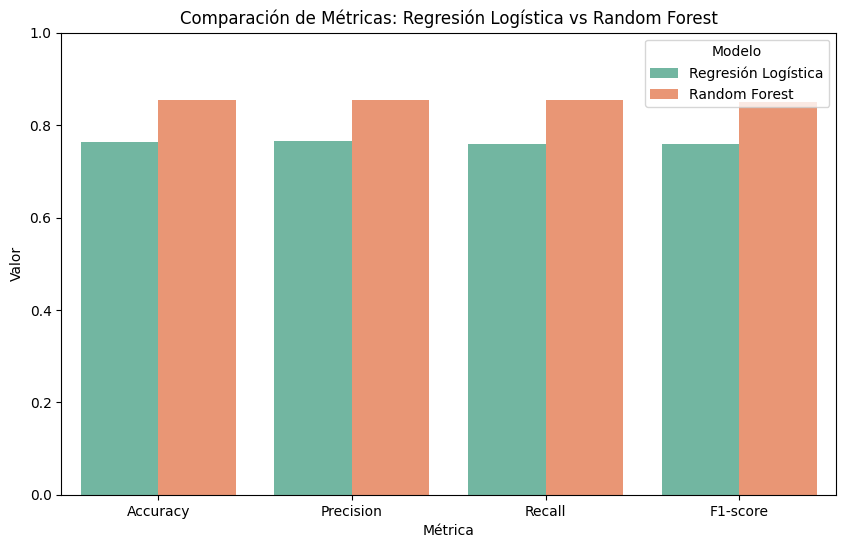

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Crear DataFrame con métricas ---
metrics_data = {
    'Modelo': ['Regresión Logística', 'Regresión Logística', 'Regresión Logística', 'Regresión Logística',
               'Random Forest', 'Random Forest', 'Random Forest', 'Random Forest'],
    'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-score',
                'Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Valor': [0.764, (0.79+0.74)/2, (0.72+0.80)/2, 0.76,
              0.854, (0.84+0.87)/2, (0.88+0.83)/2, 0.85]
}

df_metrics = pd.DataFrame(metrics_data)

# --- Visualización ---
plt.figure(figsize=(10,6))
sns.barplot(x='Métrica', y='Valor', hue='Modelo', data=df_metrics, palette='Set2')
plt.ylim(0,1)
plt.title("Comparación de Métricas: Regresión Logística vs Random Forest")
plt.ylabel("Valor")
plt.xlabel("Métrica")
plt.legend(title='Modelo')
plt.show()
